## **Setup**

In [1]:
!pip install wandb   # run this command to insatll wandb on colab - worth it!

     |████████████████████████████████| 1.6MB 8.2MB/s 
     |████████████████████████████████| 163kB 51.3MB/s 
     |████████████████████████████████| 102kB 16.0MB/s 
     |████████████████████████████████| 102kB 15.4MB/s 
     |████████████████████████████████| 122kB 46.2MB/s 
     |████████████████████████████████| 71kB 12.0MB/s 
  Created wheel for subprocess32: filename=subprocess32-3.5.4-cp36-none-any.whl size=6489 sha256=beb78b1d1fbeb2f301c6a8109d925faa2c84720bad9db25e71e779c97c89dd66
  Stored in directory: /root/.cache/pip/wheels/68/39/1a/5e402bdfdf004af1786c8b853fd92f8c4a04f22aad179654d1
  Created wheel for watchdog: filename=watchdog-0.10.3-cp36-none-any.whl size=73873 sha256=1ebac0361b1df211baa7ab6fc60ab54eee5ffec5ff7bbb925db4f52e08e5ce93
  Stored in directory: /root/.cache/pip/wheels/a8/1d/38/2c19bb311f67cc7b4d07a2ec5ea36ab1a0a0ea50db994a5bc7
  Created wheel for pathtools: filename=pathtools-0.1.2-cp36-none-any.whl size=8785 sha256=3f417ec9d98b04da6ed6992ba772d627375043f2b61

In [2]:
import os
import random
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import sys

from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, Input
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import AUC
from tensorflow.keras.callbacks import EarlyStopping

import wandb
from wandb.keras import WandbCallback

from sklearn.metrics import roc_auc_score, roc_curve, auc
from matplotlib.colors import LinearSegmentedColormap
from termcolor import colored

from tensorflow.keras.applications import ResNet50, VGG19, InceptionResNetV2
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet50_preprocess_input
from tensorflow.keras.applications.vgg19 import preprocess_input as vgg19_preprocess_input
from tensorflow.keras.applications.inception_resnet_v2 import preprocess_input as inception_resnet_v2_preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator


# Set seed for reproducibility of results
seed_value = 0
os.environ['PYTHONHASHSEED']=str(seed_value)
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'

tf.compat.v1.reset_default_graph()

random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)
tf.compat.v1.set_random_seed(seed_value)

# Configure a new global `tensorflow` session
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)

tf.__version__

'2.3.0'

In [3]:
from google.colab import drive
mount_path = '/content/gdrive/'
drive.mount(mount_path)

Mounted at /content/gdrive/


In [4]:
# Set and test path to competition data files
competition_path = 'My Drive/Final Project ITC/MAFAT Challenge/Data'
try:
  if competition_path == 'INSERT HERE':
    print('Please enter path to competition data files:')
    competition_path = input()
  file_path = 'MAFAT RADAR Challenge - Training Set V1.csv'
  with open(f'{mount_path}/{competition_path}/{file_path}') as f:
    f.readlines()
  print(colored('Everything is setup correctly', color='green'))
except:
  print(colored('Please mount drive and set competition_path correctly',
                color='red'))

Everything is setup correctly


## **Functions**

All functions will be used in the "Training the Model" section.

In [5]:
files_path = mount_path + "/" + "My Drive/Final Project ITC/MAFAT Challenge/Our notebooks/Inbar"

sys.path.append(files_path)

In [6]:
from loading_functions import load_data, load_pkl_data, load_csv_metadata
from spectogram_plots import plot_shited_spectrogram, plot_recenter_midline_spectrogram, spectrogram_cmap
from model_roc_function import stats
from data_augmentation import  recenter_midline, shift_spectrogram
from data_preprocessing_funcs import data_preprocess
from plot_learning_curve import plot_loss_and_accuracy_over_epoches
from data_augmentation import recenter_midline, shift_spectrogram

np.save('/content/cmap.npy', spectrogram_cmap)

### **Splitting the Training set**

The functions below split the training set into Train and Validation sets.

* Validation Set.   
The validation set is constructed from segments from geolocation_ids 1 and 4.   
These geolocations' target_type distributions are balanced.
To create a fair representation of the test set   
(one segment form each track) every sixth segment was taken to the validation set.   
The reason is that approximately 75% of the tracks have less than 6 segments,   
it guarantees that most of the segments in the validation set are not from the same track.   
   
* Adding "human" segments to the training set.   
The training set is imbalanced.   
One can address this issue by taking segements of humans from the "Auxiliary Experiment Set".   
The first 3 segments from each track are taken into the training set (or less if the track is shorter than 3 segments).

In [8]:
# Function for splitting the data to training and validation
# and function for selecting samples of segments from the Auxiliary dataset
def split_train_val(data):
  """
  Split the data to train and validation set.
  The validation set is built from training set segments of 
  geolocation_id 1 and 4. 
  Use the function only after the training set is complete and preprocessed. 

  Arguments:
    data -- {ndarray} -- the data set to split

  Returns:
    iq_sweep_burst ndarray matrices
    target_type vector 
    for training and validation sets
  """
  idx = ((data['geolocation_id'] == 4) | (data['geolocation_id'] == 1))\
   & (data['segment_id'] % 6 == 0)
  training_x = data['iq_sweep_burst'][np.logical_not(idx)]
  training_y = data['target_type'][np.logical_not(idx)]
  validation_x = data['iq_sweep_burst'][idx]
  validation_y = data['target_type'][idx]
  return training_x, training_y, validation_x, validation_y

def aux_split(data, num_segments=3):
  """
  Selects segments from the auxilary set for training set.
  Takes the first 3 segments (or less) from each track.

  Arguments:
    data {dataframe} -- the auxilary data

  Returns:
    The auxilary data for the training
  """
  idx = np.bool_(np.zeros(len(data['track_id'])))
  for track in np.unique(data['track_id']):
    idx |= data['segment_id']==(data['segment_id'][data['track_id'] == track][:3])
  
  for key in data:
    data[key] = data[key][idx]
  return data

## **Model**

After 

### **CNN Model** - transfer learning


In [9]:
# Building the model
def create_model(model_tl, init, layer, input_shape= (126, 32, 3)):
  """
  Transfer learning Resnet model. trained on imagenet
  The input shape must be RGB, hense we must duplicate the channel 3 times

  Arguments:
    input_shape -- the shape of our input
    init -- the weight initialization

  Returns:
    CNN model - with resnet inside  
  """
  tl_model = Sequential(name="transfer_learning_model")
  tl_model.add(Input(shape=input_shape))

  transfer_learning_model = model_tl(include_top=False, weights="imagenet", pooling='avg')

  tl_model.add(Model(inputs=transfer_learning_model.input, outputs=transfer_learning_model.get_layer(layer).output))
  tl_model.add(Flatten())
  
  tl_model.add(Dense(1, activation='sigmoid', kernel_initializer = init))

  # Say not to train first layer (ResNet) model. It is already trained
  tl_model.layers[0].trainable = False
  return tl_model

## **Training The Model**

#### loading the data and pre-processing

In [29]:
# The function append_dict is for concatenating the training set 
# with the Auxiliary data set segments

def append_dict(dict1, dict2):
  for key in dict1:
    dict1[key] = np.concatenate([dict1[key], dict2[key]], axis=0)
  return dict1

def load_and_split_data():

  print('[INFO] Loading and spliting the data')

  # Loading Auxiliary Experiment set - can take a few minutes
  print('[INFO] Loading Auxiliary Experiment set - can take a few minutes')
  experiment_auxiliary = 'MAFAT RADAR Challenge - Auxiliary Experiment Set V2'
  experiment_auxiliary_df = load_data(experiment_auxiliary)

  #-------------

  # Taking sample from the Auxiliary Experiment set
  train_aux = aux_split(experiment_auxiliary_df)

  #-------------

  # Training set
  print('[INFO] Loading Train set - can take a few minutes')
  train_path = 'MAFAT RADAR Challenge - Training Set V1'
  training_df = load_data(train_path)

  # Adding segments from the experiment auxiliary set to the training set
  print('[INFO] Adding segments from the experiment auxiliary set to the training set')
  train_df = append_dict(training_df, train_aux)

  # Preprocessing and split the data to training and validation
  print('[INFO] Preprocessing and split the data to training and validation')
  train_df = data_preprocess(train_df.copy())
  train_x, train_y, val_x, val_y = split_train_val(train_df)
  val_y = val_y.astype(int)
  train_y = train_y.astype(int)

  #-------------
  # Creating 3 channels for the train and validation set
  print('[INFO] Creating 3 channels for the train and validation set')
  train_x = np.repeat(train_x[...,np.newaxis], 3, -1)
  val_x = np.repeat(val_x[...,np.newaxis], 3, -1)

  #-------------

  # Public test set - loading and preprocessing
  print('[INFO] Loading and preprocessing public test set')
  test_path = 'MAFAT RADAR Challenge - Public Test Set V1'
  test_df = load_data(test_path)
  test_df = data_preprocess(test_df.copy())
  test_x = test_df['iq_sweep_burst']
  test_x = np.repeat(test_x[...,np.newaxis], 3, -1)

  return train_x, val_x, test_x, train_y, val_y 

#### ImageDataGenerator

In [11]:
def create_IDG(idg_input,train_x):
  datagen = ImageDataGenerator(
                                vertical_flip = idg_input['vertical_flip'],
                                horizontal_flip=idg_input['horizontal_flip'],
                                width_shift_range = idg_input['width_shift_range'],
                                height_shift_range=idg_input['height_shift_range'],
                                fill_mode=idg_input['fill_mode'],
                                brightness_range = idg_input['brightness_range'],
                                preprocessing_function = idg_input['preprocessing_function']
                              )
  #Fitting the Image Generator defined above to the X train data set
  datagen.fit(train_x)

  return datagen

#### model configurations

In [12]:
model_input = {
                'model_conf' : {
                              'batch_size':16,
                              'loss_function':BinaryCrossentropy(),
                              'no_epochs':50,
                              'optimizer':Adam(learning_rate = 0.001),
                              'metrics': [AUC(), 'accuracy']
                              },
               'callback' : {'early_stop':{
                                          'flag':True,
                                          'early_stop':EarlyStopping(monitor='val_accuracy', patience=5, verbose=1)
                                          },
                            'model_checkpoint':{
                                                'flag':True,
                                                'file_path':'/content/drive/My Drive/Final Project ITC/MAFAT Challenge/Saved Models/Nir/test2',
                                                'save_weights_only':False,
                                                'monitor':'val_accuracy'
                                                }
                            },
               'IDG' : {
                        'vertical_flip':False,
                        'horizontal_flip':False,
                        'width_shift_range' : 0,
                        'height_shift_range': 0,
                        'fill_mode':'nearest',
                        'brightness_range' : [1,1],
                        'preprocessing_function' : None
                        }        
                }

In [13]:
# Model configuration:

wandb.init(project="MAFAT",
           config={
              "batch_size": 32,
              "no_epochs":100,
              "learning_rate":0.001
           })

img_width, img_height = 126, 32
loss_function = BinaryCrossentropy()
optimizer = Adam(learning_rate = wandb.config.learning_rate)

init = tf.keras.initializers.GlorotNormal(seed = 0)

input_shape = (img_width, img_height, 3)  # must be 3 is RGB for using transfer learning

# callbacks
earlystop = EarlyStopping(monitor='val_accuracy', patience=5, verbose=1)

<IPython.core.display.Javascript object>

wandb: You can find your API key in your browser here: https://wandb.ai/authorize


wandb: Paste an API key from your profile and hit enter: ··········


wandb: Offline run mode, not syncing to the cloud.
wandb: Tracking run with wandb version 0.10.2
wandb: W&B is disabled in this directory.  Run `wandb on` to enable cloud syncing.
wandb: Run data is saved locally in wandb/offline-run-20200923_121334-33jews9c


#### Loading the data


In [30]:
train_x, val_x, test_x, train_y, val_y = load_and_split_data()

[INFO] Loading and spliting the data
[INFO] Loading Auxiliary Experiment set - can take a few minutes


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:38: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


[INFO] Loading Train set - can take a few minutes
[INFO] Adding segments from the experiment auxiliary set to the training set
[INFO] Preprocessing and split the data to training and validation
[INFO] Creating 3 channels for the train and validation set
[INFO] Loading and preprocessing public test set


In [41]:
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
cm_data = np.load('/content/cmap.npy')
color_map = LinearSegmentedColormap.from_list('parula', cm_data)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


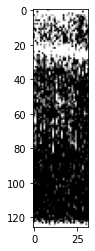

In [43]:
plt.imshow(train_x[8], cmap=color_map)

In [47]:
img = Image.fromarray(train_x[8], 'RGB')
img.show()

In [51]:
#Define Model
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))
#Compile
model.compile(optimizer=optimizer, loss=loss_function, metrics=['AUC', 'accuracy'])
print(model.summary())
#Train and Test The Model
model.fit(train_x, train_y, batch_size=4, epochs=10, validation_data=(val_x, val_y))

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 124, 30, 32)       896       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 122, 28, 64)       18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 61, 14, 64)        0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 61, 14, 64)        0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 54656)             0         
_________________________________________________________________
dense_7 (Dense)              (None, 128)               6996096   
_________________________________________________________________
dropout_7 (Dropout)          (None, 128)              

ValueError: ignored

### VGG19

In [15]:
# Creating and running the model
vgg_19_model = create_model(VGG19, init, "block5_conv2", input_shape)  
vgg_19_model.compile(loss=loss_function, optimizer=optimizer, metrics=['AUC', 'accuracy'])
#vgg_19_model.compile(loss=config.loss_function, optimizer=config.optimizer, metrics=config.metrics)
vgg_19_model.summary()

80142336/80134624 [==============================] - 0s 0us/step
Model: "transfer_learning_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
functional_1 (Functional)    (None, None, None, 512)   15304768  
_________________________________________________________________
flatten (Flatten)            (None, 7168)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 7169      
Total params: 15,311,937
Trainable params: 7,169
Non-trainable params: 15,304,768
_________________________________________________________________


In [23]:
%%wandb

datagen = create_IDG(model_input['IDG'],train_x)

history_vgg19 = vgg_19_model.fit(datagen.flow(train_x, train_y, batch_size=wandb.config.batch_size),
          steps_per_epoch=len(train_x) // wandb.config.batch_size,
          epochs=wandb.config.no_epochs,
          validation_data=(val_x, val_y),
          validation_steps=len(val_x) // wandb.config.batch_size,
          callbacks=[earlystop, WandbCallback(data_type="image", validation_data=(val_x, val_y))])
          

AttributeError: ignored

Epoch 1/100
205/205 [==============================] - 5s 26ms/step - loss: 1.2316 - auc: 0.9401 - accuracy: 0.9666 - val_loss: 0.4466 - val_auc: 0.9074 - val_accuracy: 0.8511
Epoch 2/100
205/205 [==============================] - 5s 25ms/step - loss: 2.0369 - auc: 0.9298 - accuracy: 0.9627 - val_loss: 0.5577 - val_auc: 0.9078 - val_accuracy: 0.7994
Epoch 3/100
205/205 [==============================] - 5s 25ms/step - loss: 2.5455 - auc: 0.9223 - accuracy: 0.9587 - val_loss: 0.6226 - val_auc: 0.8835 - val_accuracy: 0.7929
Epoch 4/100
205/205 [==============================] - 5s 25ms/step - loss: 1.2759 - auc: 0.9493 - accuracy: 0.9722 - val_loss: 0.6507 - val_auc: 0.8953 - val_accuracy: 0.7832
Epoch 5/100
205/205 [==============================] - 5s 25ms/step - loss: 1.1560 - auc: 0.9533 - accuracy: 0.9749 - val_loss: 0.6536 - val_auc: 0.8982 - val_accuracy: 0.7832
Epoch 6/100
205/205 [==============================] - 5s 25ms/step - loss: 1.3239 - auc: 0.9522 - accuracy: 0.9732 - va

## **Results**

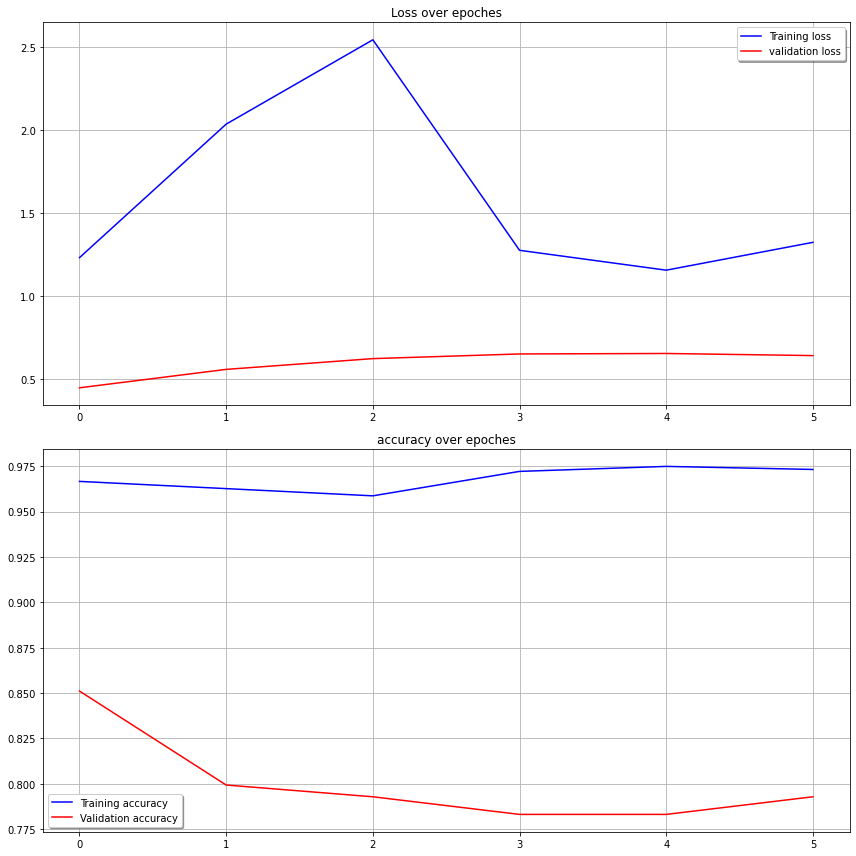

In [24]:
plot_loss_and_accuracy_over_epoches(history_vgg19)

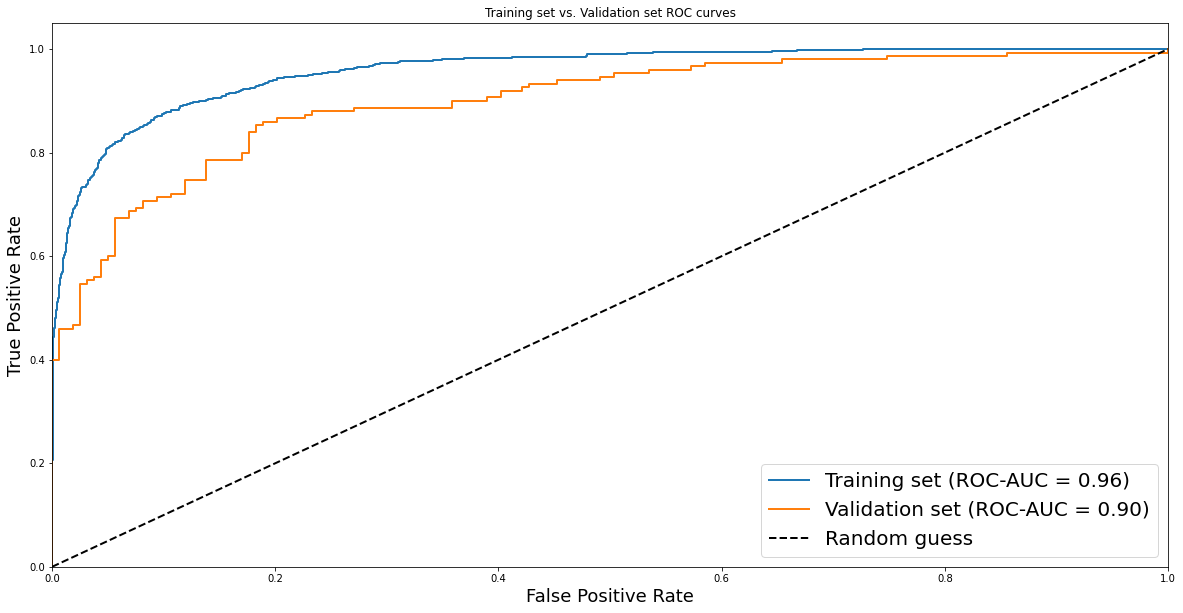

In [25]:
# Plot ROC curve and show ROC-AUC results of the training and validation sets. 
pred = [vgg_19_model.predict(train_x), vgg_19_model.predict(val_x)]
actual = [train_y, val_y]
stats(pred, actual)

In [22]:
# Creating DataFrame with the probability prediction for each segment
submission =  pd.DataFrame()
submission['segment_id'] = test_df['segment_id']
submission['prediction'] = vgg_19_model.predict(test_x)
submission['prediction'] = submission['prediction'].astype('float')

# Save submission
submission.to_csv('submission.csv', index=False)

NameError: ignored

In [ ]:
# Download zip file
from zipfile import ZipFile
from google.colab import files

with ZipFile('submission.zip', 'w') as myzip:
  myzip.write('submission.csv')

files.download('submission.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>